**Super-Resolution Tutorial** By Chuan Tan

This tutorial is based off the work I did in my dissertation. It tries to convey the main ideas of my dissertation and guides users through Super-Resolution using Deep Neural Networks. Note that this is but just a small subset of the work I did for my dissertation. For the full work that I have done, see https://github.com/pancakewaffles/meta-srgan.

Super-Resolution is generally divided into two types: Single-Image Super-Resolution and Multiple-Images Super-Resolution. The former seeks to upscale an image based on a single image, whilst the latter incorporates information from several sources to upscale an image. Multiple-Images Super-Resolution takes more effort and requires more data, and hence will not be covered in this tutorial. We will focus mainly on Single-Image Super-Resolution.

To follow this tutorial you need a basic understanding of Python 3 (file operations, classes, numpy and pandas), and PyTorch 1.0.0. You need to know what convolution is, what backpropagation is, and how to construct a neural network in general.

This tutorial is self-contained. That is, you will be implementing your own Meta-SRGAN, using the BSDS300 dataset. We are not using the DIV2K dataset as that dataset is huge - about 4GB compressed. That's huge and you wouldn't want to waste time uploading it. For the sake of brevity, and for the purposes of this tutorial only, we will be using the BSDS300 dataset. Whilst this is a segmentation dataset, Super-Resolution can be helpful and improve the performance of segmentation by making images clearer.

Grab the BSDS300 dataset [here](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz), and then place it next to the jupyter notebook.


**Prerequisites**

You will need:


*   PyTorch (with CUDA preferably)
*   Matplotlib
*   Numpy
*   Pandas
*   tqdm
*   PIL

So install them if you haven't or run this on Google Colab.



This tutorial is structured as follows:
  1. We will first take a look at traditional Super-Resolution techniques such as interpolation. We will go through linear, bilinear and bicubic interpolation. We will then implement bicubic interpolation and see how it works on a typical image.

  2. We will then take a look at a state-of-the-art implementation for Super-Resolution (EDSR, [paper here](https://arxiv.org/pdf/1707.02921.pdf)). It won the 2017 NTIRE Super-Resolution Challenge so that's an achievement. We will see how it uses Shi's Efficient Sub-pixel Convolution to do the upsampling. We also see how this constrains Super-Resolution to only work on certain upscaling factors.

  3. We will then look at Meta-SRGAN, which replaces Shi's Convolution layer with Hu's Meta-Upscale Module ([paper here](https://arxiv.org/pdf/1903.00875.pdf)) and combines it with SRGAN ([paper here](https://arxiv.org/pdf/1609.04802.pdf)). SRGAN manages to achieve visually realistic images compared to other other networks.

First, we extract the dataset.

In [0]:
import tarfile
import os
if not os.path.isdir("BSDS300"):
  tf = tarfile.open("BSDS300-images.tgz")
  tf.extractall()

Then, we import all our libraries.

In [0]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import imageio
import matplotlib.pyplot as plt
import math
import numpy as np
import random
from tqdm import tqdm_notebook

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # This sets us up to use GPU if possible. If not,  we will revert back to using CPU.

Let's wrap our dataset in a PyTorch Dataset class to make things more "PyTorch friendly". Read [this](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) if you have no clue what's going on. Basically, the PyTorch Dataset class provides a wrapper to handle our dataset, making it extremely easy if we wish to make changes to the image or modify them.

Here, we artificially increase the size of the dataset by obtaining 16 random patches from each image. This means we would have 16 * 200 training patches. Great!

In [0]:
# Create our own custom Dataset.

train_dir = './BSDS300/images/train'
test_dir = './BSDS300/images/test'

class TrainDatasetFromFolder(Dataset):
  def __init__(self,image_dir, num_patches=16, crop_size = 128):
    """
    A custom dataset. This takes after the PyTorch dataset class. It creates a dataset from a folder.
    In particular, this creates a dataset from the training directory. All it does is return 
    two tensors, one of the input image, the other of the ground truth / target image.
    :param image_dir: Directory of training images.
    :param num_patches: Number of patches per training image. This can drastically extend our
    training data set.
    :param crop_size: Size of each patch.
    """
    super(TrainDatasetFromFolder,self).__init__()
    # image_filenames is a list of pointers to the image. To optimise for memory, we almost always pass pointers. We only get the image if we wish to access them.
    self.image_filenames = [os.path.join(image_dir,x) for x in os.listdir(image_dir)]
    self.num_patches = num_patches
    self.crop_size = crop_size
    
  def __getitem__(self,index):
    """
    Gets a pair of input and target (ground truth) images.
    :param index: the index of the image to obtain the pair of input and target images from. 
    The code index = index // self.num_patches provides a space-efficient way to
    obtain multiple patches per image without creating those patches in the first place.
    :return (input, target): A tuple of tensors of input image and target image.
    """
    index = index // self.num_patches 
    img = Image.open(self.image_filenames[index]).convert('YCbCr') # Let's work with Grayscale images because they are simpler. To work with RGB images, simply use 'RGB'.
    crop_size = self.crop_size
    img = patch_transform(crop_size)(img) # This function will be explained later.
    y, _,_ = img.split()
    input = y # We grab only the Y component of the image. This is the grayscale.
    target = input.copy() # We make a copy of the image.
    
    return transforms.ToTensor()(input), transforms.ToTensor()(target)

  
  def __len__(self):
    """
    Returns the number of training data in the data folder.
    This is artificially boosted with the number of patches to increase
    training data.
    """
    return len(self.image_filenames) * self.num_patches 
  
class TestDatasetFromFolder(Dataset):
  def __init__(self,image_dir, crop_size = 128):
    """
    A custom dataset. This takes after the PyTorch dataset class. It creates a dataset from a folder.
    In particular, this creates a dataset from the test directory. All it does is return 
    two tensors, one of the input image, the other of the ground truth / target image.
    :param image_dir: Directory of test images.
    :param num_patches: Number of patches per test image. This can drastically extend our
    test data set.
    :param crop_size: Size of each patch.
    """
    super(TestDatasetFromFolder,self).__init__()
    self.image_filenames = [os.path.join(image_dir,x) for x in os.listdir(image_dir)]
    self.crop_size = crop_size
    
  def __getitem__(self,index):
    """
    Gets a pair of input and target (ground truth) images.
    :param index: the index of the image to obtain the pair of input and target images from. 
    The code index = index // self.num_patches provides a space-efficient way to
    obtain multiple patches per image without creating those patches in the first place.
    :return (input, target): A tuple of tensors of input image and target image.
    """
    img = Image.open(self.image_filenames[index]).convert('YCbCr') # RGB
    
    crop_size = self.crop_size
    img = test_transform(crop_size)(img) # This function will be explained later.
    y, _,_ = img.split()
    input = y
    target = input.copy()
    
    return transforms.ToTensor()(input), transforms.ToTensor()(target)
  
  def __len__(self):
    """
    Returns the number of testing data in the data folder.
    We keep the size of the testing dataset the same because we are not training on them and hence do not need that many patches.
    """
    return len(self.image_filenames)

In [0]:
# The patch transform function extracts out a random patch from an image. It takes in the crop size (an integer indicating a square crop) and returns a function that performs that transformation.
def patch_transform(crop_size):
  """Transform function for a patch.
  :param crop_size: Size of a patch."""
  return transforms.RandomCrop(crop_size)

# The test transform function extracts out the center crop of the image. The idea is that this would make testing consistent, as each test would be run on the same images. Consistent tests would make performance comparisons between models fairer.
def test_transform(crop_size):
  """Transform function for test data. Basically just crops the center of the test data.
  :param crop_size: Size of crop that we wish to do."""
  return transforms.CenterCrop(crop_size)

We then wrap the Dataset further in a DataLoader class. A DataLoader class enables us to deliver batches of images, which will be useful when we are training Meta-SRGAN, as each batch can be associated with a scale.

In [0]:
# Load training and test datasets.
'''
Feel free to change BATCH_SIZE and PATCH_CROP_SIZE. They define the batch size and patch crop size respectively.
'''
BATCH_SIZE = 4 
PATCH_CROP_SIZE = 96

train_set = TrainDatasetFromFolder(train_dir,
                              num_patches=16,
                                  crop_size=PATCH_CROP_SIZE)

training_data_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE,shuffle=True)

# Remember, test_set is just a set of the center crops of each image in test folder. There are no "patches" in test set.
test_set = TestDatasetFromFolder(test_dir,
                                crop_size=PATCH_CROP_SIZE)
testing_data_loader = DataLoader(dataset=test_set, batch_size=1,shuffle=False)

We can visualise the images extracted.

0: Input shape: torch.Size([1, 96, 96]) , Target shape: torch.Size([1, 96, 96])
1: Input shape: torch.Size([1, 96, 96]) , Target shape: torch.Size([1, 96, 96])


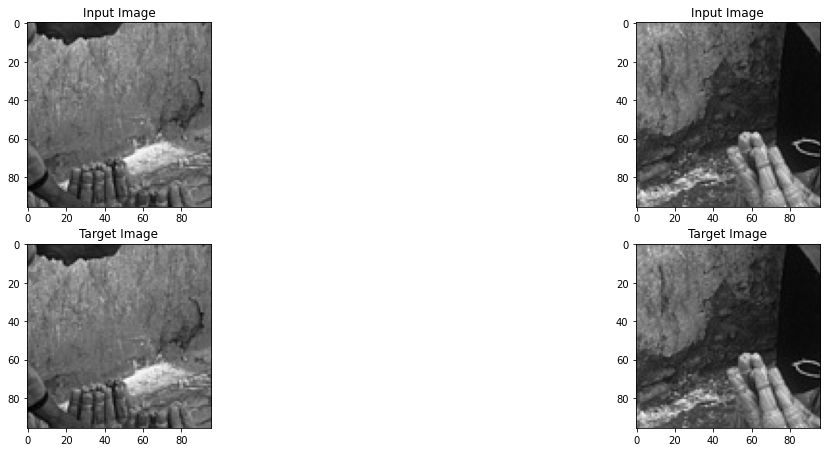

In [0]:
unloader = transforms.ToPILImage()
fig = plt.figure(figsize=(20, 40))

# Printing out the first two images.
for i in range(2): 
  sample_input, sample_target  = train_set[i]
  print("{}: Input shape: {} , Target shape: {}".format(i,sample_input.shape, sample_target.shape))
  subplot = fig.add_subplot(10, 2, i+1)
  plt.imshow(unloader(sample_input), cmap='gray')
  plt.title("Input Image")
  subplot = fig.add_subplot(10, 2, i+3)
  plt.imshow(unloader(sample_target), cmap='gray')
  plt.title("Target Image")

We see that the input image and the target image are the same sizes. Don't worry, this is crucial for our batch processor to work. Let's define that now.

The batch processor essentially takes a batch from the DataLoader, downscales the input image "on-the-fly" and then pushes the images to the neural network. Whilst this may slow things a bit, it more than makes up for it in its flexibility to assign each batch an upscaling factor, a feature that will be tremendously useful in training Meta-SRGAN.

In [0]:
def process_batch(batch):
  """
  Processes a batch. A batch consists
  :param batch: Consists of a tuple (inputs, targets). Inputs is a batch of input images.
  Targets is the batch of the corresponding target or ground truth images.
  :return (new_inputs, new_targets, scale): Transformed inputs, transformed targets, and the scale
  with which the current batch is using.
  """
  inputs, targets = batch
  scales = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0]
  # For each batch, use a different test_scale.
  scale = np.random.choice(scales)
  # Process inputs and targets
  N, C, H, W = inputs.shape
  crop_size = H # crop_size is the size of the initial crop, usually 128
  new_inputs = []
  new_targets = []
  for i in range(N):
    input = inputs[i]
    target = targets[i]
    input = input_transform(crop_size,scale)(input) # Downscales the input to become the low-resolution input to neural network.
    target = target_transform( int(int(crop_size // scale) * scale) )(target) # We do this because when multiplying non-integer scales, the dimensions of the super-resolved image may not match may go awry. This sets it back.
    new_inputs.append(input)
    new_targets.append(target)
    
  
  return torch.stack(new_inputs), torch.stack(new_targets), scale # Note how we associated each batch with an upscaling factor.

In [0]:
# And the input and target transforms.
def input_transform(crop_size, upscale_factor):
  """Transform function for the input. This crops the input to int(crop_size // upscale_factor),
  and converts the image to tensor form. In tensor form, each pixel ranges from 0.0 to 1.0."""
  return transforms.Compose([
       transforms.ToPILImage(),
       transforms.Resize(int(crop_size // upscale_factor)),
       transforms.ToTensor()
  ])

def target_transform(target_crop_size):
  """Transform function for the target. The target is the ground truth to which the 
  super-resolved image is compared against. This resizes the image to target_crop_size,
  and converts the image to tensor form. 
  :param target_crop_size: size of target or ground truth image.
  target_crop_size = int(int(crop_size // scale) * scale) """
  return transforms.Compose([
       transforms.ToPILImage(), 
       transforms.Resize(target_crop_size),
       transforms.ToTensor()
  ])

Great! Now we can do some interpolations.

**Part I: Interpolation**

Interpolation is the idea of creating new pixels using old pixel values. Several examples of interpolation are shown in the diagram below ![alt text](https://bit.ly/2VDulY7) (Image taken from Wikipedia).

Nearest neighbour is simple, we simply assign the pixel value of the new pixel to the nearest pixel value. Linear interpolation takes the weighted average of two pixels in one-dimension, whilst bilinear interpolation is an extension of linear interpolation in two-dimensions - thus it can be used for images. It basically just does linear interpolation in each dimension. However the performance may be bad, and so we use bicubic interpolation, which samples 16 neighbours and takes the weighted average. Bicubic interpolation takes into account derivatives to create a smooth image, so the image output may appear blurry.

Nearest neighbour, bilinear, and bicubic are simple to do in PyTorch:

In [0]:
def bicubic_interpolation(H,W,scale):
  """
  This does bicubic interpolation by leveraging on PyTorch's own transforms library.
  :param H: Height of input image.
  :param W: Width of input image.
  :param scale: Scale by which to upsample.
  """
  return transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((int(H*scale), int(W*scale)), interpolation=Image.BICUBIC), # We can modify the type of interpolation by simply tweaking this.
        transforms.ToTensor()
      ])

Let's now see Bicubic Interpolation in action!

Because of the batch processing which assigns a random scale to each batch, every time you run the below function it gives you a different scale. The input is the low-resolution input, output is the interpolation, and target is the high-resolution image that it's supposed to match.

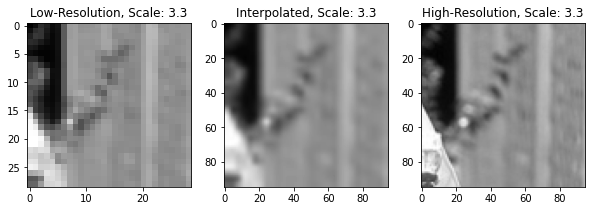

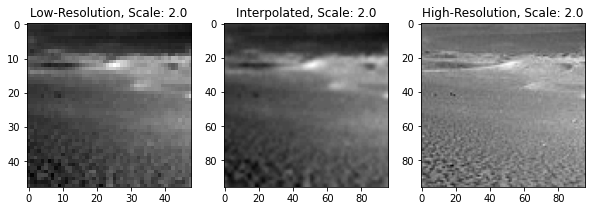

In [0]:
  with torch.no_grad():
    for i, (inputs, targets) in enumerate(testing_data_loader):
      if i == 2:
        break
      inputs, targets, test_scale = process_batch((inputs,targets))
      N,C,H,W = inputs.size()
      predictions = []
      for j in range(N):
        prediction = bicubic_interpolation(H,W,test_scale)(inputs[j])
        predictions.append(prediction)
        
      predictions = torch.stack(predictions)
      N , C, H, W = predictions.size()
      
      fig = plt.figure(figsize=(10,5))
      subplot = fig.add_subplot(1, 3, 1)
      subplot.imshow(transforms.ToPILImage()(inputs[0].cpu()), cmap="gray")
      subplot.title.set_text('Low-Resolution, '+ 'Scale: ' + str(test_scale))

      subplot = fig.add_subplot(1, 3, 2)
      subplot.imshow(transforms.ToPILImage()(predictions[0].cpu()), cmap="gray")
      subplot.title.set_text('Interpolated, ' + 'Scale: ' + str(test_scale))

      subplot = fig.add_subplot(1, 3, 3)
      subplot.imshow(transforms.ToPILImage()(targets[0].cpu()), cmap="gray")
      subplot.title.set_text('High-Resolution, '+ 'Scale: ' + str(test_scale))
      plt.show()

**Part II: EDSR and Shi's Efficient Sub-Pixel Convolution Layer**
Enhanced Deep Residual Networks for Super-Resolution ([paper here](https://arxiv.org/pdf/1707.02921.pdf)) is a type of Convolutional Neural Network that does Super-Resolution. Its powerful abilities to super-resolve comes from the fact that it utlises Residual Blocks, which add the input to the output to give a sense of incremental change. The use of Residual Blocks contributed to EDSR's achievement at the 2017 NTIRE Super-Resolution Challenge.

The layers we will be using are:

*   Convolution Layer
*   ReLU Layer
* PixelShuffle - PixelShuffle implements Shi's Efficient Sub-Pixel Convolution Layer (We will take a further look at this)

Let's do this bottom up. First let's build the Residual Block.



In [0]:
# EDSR  
class ResidualBlock(nn.Module):
    def __init__(self, n_feats=64, kernel_size=3,res_scale=1):
      """
      Builds a Residual Block. A ResBlock contains a Conv2d, ReLU activation, 
      Conv2d, ReLU activation and Multiply.
      :param n_feats: Number of channels in each convolution.
      :param kernel_size: Window size in each convolution.
      :param res_scale: Amount to multiply the data with in the multiply block.
      """
      super(ResidualBlock,self).__init__()
      self.n_feats = n_feats
      self.kernel_size = kernel_size
      self.res_scale = res_scale
      self.build_block()

    def build_block(self):
      """
      Actually builds the Residual Block. A ResBlock contains a Conv2d, ReLU activation, 
      Conv2d, ReLU activation and Multiply.
      """
      self.block1 = nn.Sequential(
          nn.Conv2d(self.n_feats,self.n_feats,self.kernel_size,stride=1,padding=1,bias=True),
          nn.ReLU(),
          nn.Conv2d(self.n_feats,self.n_feats,self.kernel_size,stride=1,padding=1,bias=True),
          nn.ReLU()
      )

    def forward(self,x):
      """
      Forward propagates through the block.
      :param x: Input features.
      :return: Output of the ResBlock, of size (batch_size, n_feats, input_H, input_W)
      """
      res = self.block1(x)
      res = res.mul(self.res_scale)
      res += x # Notice here where we add the input to the output.
      return res


Now, let's combine the Residual Blocks in a way that allows us to add the inputs to the outputs.

In [0]:
# EDSR
class EDSR(nn.Module):
  def __init__(self,in_channels=1, out_channels=1,n_feats=64,rgb_range=255, num_resblocks=32,res_scale=1, upscale_factor=2):
    """
    Builds a EDSR network.
    :param in_channels: Number of input channels. Must be same as number of output channels. 
    If RGB images, use 3, if grayscale, use 1.
    :param out_channels: Number of output channels. If RGB images, use 3, if grayscale, use 1.
    :param n_feats: Number of channels in the convolution.
    :param rgb_range: RGB range. Either 0-255 or 0.0-1.0. Converting images to PyTorch tensors usually makes them 0.0-1.0.
    :param num_resblocks: Number of ResBlocks in the network.
    :res_scale: Residual scaling factor. Used in ResBlocks.
    """
    super(EDSR,self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.n_feats = n_feats
    self.rgb_range = rgb_range
    self.num_resblocks = num_resblocks
    self.res_scale = res_scale
    self.upscale_factor = upscale_factor
    self.build_network()

  def build_network(self):
    """
    Actually builds the network. It includes 3 blocks. The first block is just a convolution.
    The second block is a bunch of residual blocks. The number of residual blocks is specified in num_resblocks.
    The third block is the upsampling block.
    """
    block1 = [nn.Conv2d(self.in_channels,self.n_feats,3,stride=1,padding=1)]

    block2 = [ResidualBlock(n_feats=self.n_feats,res_scale=self.res_scale) for _ in range(self.num_resblocks)]
    block2.append(nn.Conv2d(self.n_feats,self.n_feats,3,stride=1,padding=1)) # We append a conv2d at the end of ResBlocks, before the addition, much like the paper.

    block3 = [Upsampler(self.upscale_factor,n_feats=self.n_feats),
             nn.Conv2d(self.n_feats ,self.out_channels,3,stride=1,padding=1)]
    
    
    self.block1 = nn.Sequential(*block1)
    self.block2 = nn.Sequential(*block2)
    self.block3 = nn.Sequential(*block3)
 
  def forward(self,x):
    """
    Forward propagates through the network.
    :param x: input low-resolution image.
    :return: Super-resolved image, of size (batch_size, out_channels, upscale_factor*input_H, upscale_factor*input_W)
    """
    x = self.block1(x)
    res = self.block2(x)
    res += x  # Here we add the global output to the global input.
    x = self.block3(res) 
    return x

Notice that block3 is the Upsampler. This is a scale-dependent block. The number of Convolution Layers in this block depends on the scale. Our scale also has to a multiple of 2^n. This is because of Shi's Efficient Sub-Pixel Convolution Layer.

We see how it imposes a constraint on the neural network, such that the number of layers in the network depends on the scale. This is inefficient as each upscaling factor would require a separate neural network.

Let's define the Upsampler now.

In [0]:
class Upsampler(nn.Module):
    def __init__(self, scale, n_feats=64):
      """
      Builds the upsampling block. This upsampling is based on Efficient Sub-Pixel Convolution
      by Shi et al. https://arxiv.org/pdf/1609.05158.pdf. It includes a Conv2d,
      a PixelShuffle, a BatchNorm2d, and a ReLU activation. The Conv2d extends the information
      so that PixelShuffle can use it to upsample the image.
      :param scale: Scale to upsample it to. Must be a multiple of 2^n.
      :param n_feats: Number of channels in the input.
      """
      super(Upsampler,self).__init__()
      self.scale = scale
      self.n_feats = n_feats
      self.build_block()

    def build_block(self):
      """
      Actually builds the Upsampling Block. It includes a Conv2d,
      a PixelShuffle, a BatchNorm2d, and a ReLU activation.
      """
      m = []
      if(self.scale & (self.scale-1)) == 0: # Is scale = 2^n?
        for _ in range(int(math.log(self.scale,2))): # If we are upscaling 2^n times, then build n blocks.
          m.append(nn.Conv2d(self.n_feats, 4 * self.n_feats, 3, stride=1,padding=1))
          m.append(nn.PixelShuffle(2))
          m.append(nn.BatchNorm2d(self.n_feats))
          m.append(nn.ReLU())
      self.block1 = nn.Sequential(*m)

    def forward(self,x):
      """
      Forward propagates through the block.
      :return: Output of the upsampling block, of size (batch_size, n_feats, upscale_factor*input_H, upscale_factor*input_W)
      """
      out = self.block1(x)
      return out

And that's it for EDSR! Before we train and test it, we need to implement the evaluation metrics, PSNR and SSIM. These correspond to the pixel-wise mean squared difference between two images and a proxy for the visual quality between the two images.

**Evaluation Metrics: PSNR and SSIM**

PSNR measures the peak signal-to-noise ratio of two images. Essentially this is the pixel-wise mean-squared difference between two images. It can be implemented in PyTorch simply using the nn.MSELoss() function.

SSIM is a bit trickier to implement, so we are using a PyTorch implementation by Po-Hsun-Su [reference](https://github.com/Po-Hsun-Su/pytorch-ssim).


In [0]:
# Define PSNR.
def PSNR(pred, gt):
  """
  This function calculates the peak signal-to-noise ratio of two images.
  :param pred: Super-resolved image.
  :param gt: Ground truth / target image.
  :return PSNR score between the two images.
  """
  mse = nn.MSELoss()(pred,gt)
  return 10 * math.log10(1.0 / mse)

In [0]:
# Define SSIM.
def gaussian(window_size, sigma):
    gauss = torch.Tensor([math.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

Now we train EDSR!

Wait, before we do that, just a note on how images are usually processed and trained on in convolutional neural networks. People often *normalise* the images before training on them, and after they pass out through the network we *unnormalise* them.

Feel free to not use normalisation. Experiment with it and see how it affects the network's performance.

Also, our batch processor also assigns a scale to each batch, but EDSR can only work with one scale, so let's just set that to 2.

In [0]:
class Normalise(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        :param tensor: Tensor image of size (C, H, W) to be normalised.
        :return normalised image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
          t.sub_(m).div_(s)
        return tensor

class UnNormalise(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        :param tensor: Tensor image of size (C, H, W) to be normalised.
        :return normalised image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

# The mean and std of the BSDS300 dataset; I precalculated it for us.
MEAN = (0.441,)
STD = (0.139,)
normalise = Normalise(MEAN, STD)
unnormalise = UnNormalise(MEAN,STD)

In [0]:
# Let's re-instantiate our batch processor to always select scale = 2.0.
def process_batch(batch):
  """
  Processes a batch. A batch consists
  :param batch: Consists of a tuple (inputs, targets). Inputs is a batch of input images.
  Targets is the batch of the corresponding target or ground truth images.
  :return (new_inputs, new_targets, scale): Transformed inputs, transformed targets, and the scale
  with which the current batch is using.
  """
  inputs, targets = batch
  scales = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0]
  # For each batch, use a different test_scale.
  #scale = np.random.choice(scales)

  scale = 2.0 

  # Process inputs and targets
  N, C, H, W = inputs.shape
  crop_size = H # crop_size is the size of the initial crop, usually 128
  new_inputs = []
  new_targets = []
  for i in range(N):
    input = inputs[i]
    target = targets[i]
    input = input_transform(crop_size,scale)(input) # Downscales the input to become the low-resolution input to neural network.
    target = target_transform( int(int(crop_size // scale) * scale) )(target) # We do this because when multiplying non-integer scales, the dimensions of the super-resolved image may not match may go awry. This sets it back.
    new_inputs.append(input)
    new_targets.append(target)
    
  
  return torch.stack(new_inputs), torch.stack(new_targets), scale # Note how we associated each batch with an upscaling factor.

Now we can train EDSR!

The loss functions we use for EDSR are L1 Loss, and... well, just L1 Loss.

First we initialise EDSR, the loss function, and the optimisers. The learning rate decreases every 20 epochs. This decrease will aid whilst training for larger number of epochs.

In [0]:
UPSCALE_FACTOR = 2
LEARNING_RATE = 1e-4
GAMMA = 0.8 # How much the new learning rate will be as a factor of the old learning rate.

model = EDSR(in_channels=1,out_channels=1,n_feats=256,rgb_range=1.0,num_resblocks=32,res_scale=0.1, upscale_factor = UPSCALE_FACTOR).to(device)
criterion = nn.L1Loss()
optimiser = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimiser,step_size=20, gamma=GAMMA)

# Let's also count the number of parameters.
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Number of parameters: " + str(params))


Number of parameters: 40720897


We see how big EDSR is. 40 million parameters is extremely heavyweight.

Then we specify the number of epochs to run.

In [0]:
num_epochs = 1
best_model = [None]
best_psnr = [0.0]
best_ssim = [0.0]

losses = []

rgb_range = 1.0
pixel_range = 255 / rgb_range

Then we define the training loop. During each loop we:

1. Grab some images from the data loader.
2. Processes it as a batch and assigns them a training scale to be trained with.
3. Load the images onto GPU.
4. (Optional) Normalise the input images.
5. Pass the input images through the neural network.
6. (Optional) Unnormalise the super-resolved images.
7. Calculates the loss.
8. Repeat for the whole dataset.

In [0]:
def train(epoch):
  tk1 = tqdm_notebook(enumerate(training_data_loader),total=len(training_data_loader),leave=False) # tqdm helps us visualise the training process.
  epoch_loss = 0
  for i, (inputs,targets) in tk1:
    inputs, targets, train_scale = process_batch((inputs,targets)) # The batch processor gives us a batch of images with its associated training scale.
    N,C,inH,inW = inputs.shape
    inputs = inputs.to(device) # Load the images onto GPU because we are training on GPU.
    targets = targets.to(device) 
    
    #inputs = normalise(inputs) # Uncomment if you wish to normalise the inputs.
    predictions = model(inputs) # Pass the inputs through the neural network.
    #predictions = unnormalise(predictions)
    loss = criterion(predictions,targets) # Calculate the loss.
    epoch_loss += loss.item()

    loss.backward() # Backpropagation.
    optimiser.step()
    optimiser.zero_grad()
    
    if i % 100 == 0: 
      print(i,inputs.shape, predictions.shape)
      print('Epoch {}: {}/{} , loss: {:.4f}'.format(epoch,i,len(training_data_loader), loss.item()))
      fig = plt.figure(figsize=(10,5))
      subplot = fig.add_subplot(1, 3, 1)
      subplot.imshow(transforms.ToPILImage()(inputs[0].cpu()), cmap="gray")
      subplot.title.set_text('Low-Res Input ' + 'Scale: ' + str(train_scale))
      
      subplot = fig.add_subplot(1, 3, 2)
      subplot.imshow(transforms.ToPILImage()(predictions[0].mul(pixel_range).clamp(0, 255).round().div(pixel_range).cpu()), cmap="gray")
      subplot.title.set_text('Super-Resolved ' + 'Scale: ' + str(train_scale))
      
      subplot = fig.add_subplot(1, 3, 3)
      subplot.imshow(transforms.ToPILImage()(targets[0].cpu()), cmap="gray")
      subplot.title.set_text('Hi-Res Target ' + 'Scale: ' + str(train_scale))
      plt.show()

    losses.append(loss.item()) # Collect the loss so that we can visualise how the loss decreases and verify that our network is training well.

  print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))

And we run it. The code above will visualise the images every 100 updates, so that we can see the progress. It will probably take a few epochs to really see any visually pleasing super-resolved images.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0 torch.Size([4, 1, 48, 48]) torch.Size([4, 1, 96, 96])
Epoch 0: 0/800 , loss: 0.0515


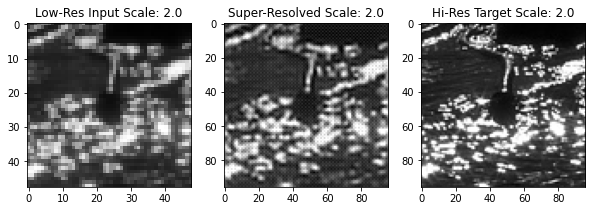

100 torch.Size([4, 1, 48, 48]) torch.Size([4, 1, 96, 96])
Epoch 0: 100/800 , loss: 0.0270


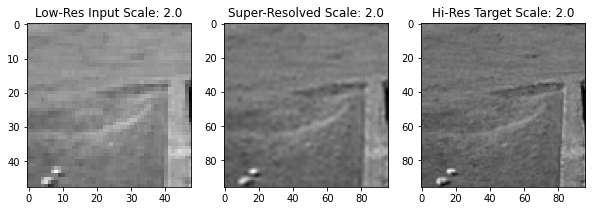

200 torch.Size([4, 1, 48, 48]) torch.Size([4, 1, 96, 96])
Epoch 0: 200/800 , loss: 0.0262


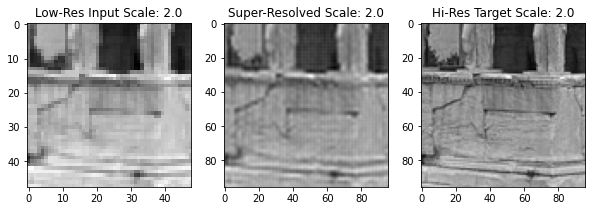

300 torch.Size([4, 1, 48, 48]) torch.Size([4, 1, 96, 96])
Epoch 0: 300/800 , loss: 0.0534


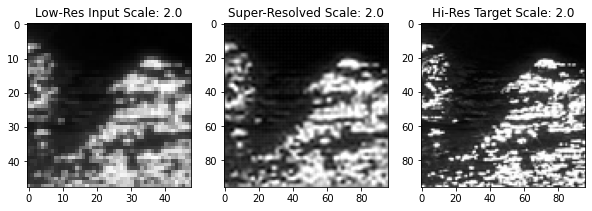

400 torch.Size([4, 1, 48, 48]) torch.Size([4, 1, 96, 96])
Epoch 0: 400/800 , loss: 0.0360


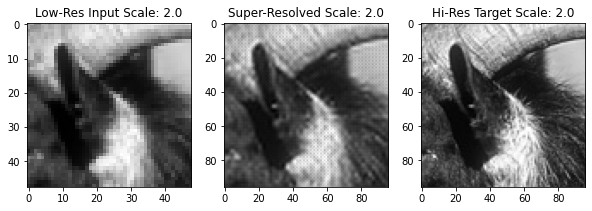

500 torch.Size([4, 1, 48, 48]) torch.Size([4, 1, 96, 96])
Epoch 0: 500/800 , loss: 0.0287


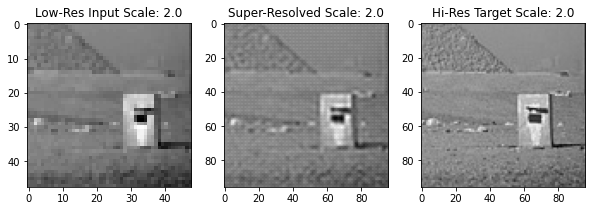

600 torch.Size([4, 1, 48, 48]) torch.Size([4, 1, 96, 96])
Epoch 0: 600/800 , loss: 0.0260


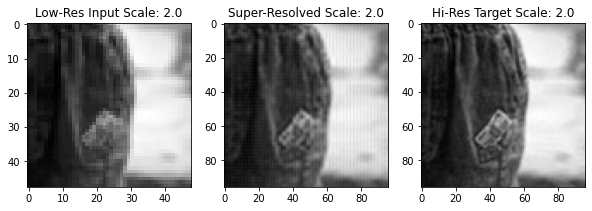

700 torch.Size([4, 1, 48, 48]) torch.Size([4, 1, 96, 96])
Epoch 0: 700/800 , loss: 0.0315


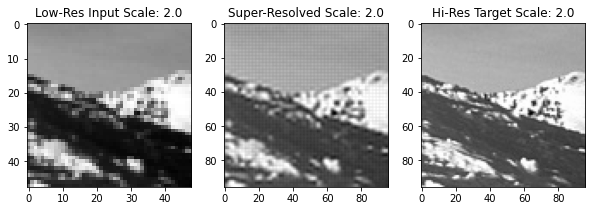

===> Epoch 0 Complete: Avg. Loss: 0.0357


In [0]:
for epoch in range(num_epochs):
  train(epoch)
  scheduler.step()

**PART III: Meta-SRGAN**

Let's now explore Meta-SRGAN and the use of a Weight Prediction Network to tackle arbitrary upscaling factors.

Meta-SRGAN is based off SRGAN ([paper here](https://arxiv.org/pdf/1609.04802.pdf)), and is effectively a Generative Adversarial Network. There are two networks being trained in a Generative Adversarial Network. There is the generator which generates an image (in this case it super-resolves an image) which is then fed into the discriminator which
discriminates between a real and a generated image (in this case it determines whether the image presented is the ground truth high-resolution, or not). This feedback from the discriminator is then used to further train the generator. Both generator and discriminator are playing a game to outbid each other. The generator tries to improve its ability to generate images that can fool the discriminator whilst the discriminator tries to improve its ability to discern real
images from generated images. This adversarial learning enables us to generate
more realistic and detailed images.

Let's build the Generator and Discriminator bottom-up.

Like EDSR, the Generator has Residual Blocks to add the inputs to the outputs. Let's implement the Residual Block.





In [0]:
# The Generator
class ResidualBlockSRGAN(nn.Module):
    def __init__(self, channels):
      """
      Builds a Residual Block. A ResBlock contains a Conv2d, BatchNorm2d, PReLU activation, 
      Conv2d, and BatchNorm2d.
      :param n_feats: Number of channels in each convolution.
      :param kernel_size: Window size in each convolution.
      :param res_scale: Amount to multiply the data with in the multiply block.
      """
      super(ResidualBlockSRGAN, self).__init__()
      self.channels = channels
      self.build_block()

    def build_block(self):
      """
      Actually builds the Residual Block. A ResBlock contains a Conv2d, BatchNorm2d, PReLU activation, 
      Conv2d, and BatchNorm2d.
      """
      self.block1 = nn.Sequential(
          nn.Conv2d(self.channels, self.channels, kernel_size=3, padding=1),
          nn.BatchNorm2d(self.channels),
          nn.PReLU(),
          nn.Conv2d(self.channels, self.channels, kernel_size=3, padding=1),
          nn.BatchNorm2d(self.channels)
      )

    def forward(self, x):
      """
      Forward propagates through the block.
      :param x: Input features.
      :return: Output of the ResBlock, of size (batch_size, n_feats, input_H, input_W)
      """
      residual = self.block1(x)
      return x + residual

Now let's combine these Residual Blocks together.

In [0]:
# The Generator
class Generator(nn.Module):
    def __init__(self,scale_factor,in_channels = 1, out_channels = 1):
      """
      Builds the Generator network.
      :param scale_factor: Scale factor which we are using.
      :param in_channels: Number of input channels. Must be same as number of output channels. 
      If RGB images, use 3, if grayscale, use 1.
      :param out_channels: Number of output channels. If RGB images, use 3, if grayscale, use 1.
      """
      super(Generator,self).__init__()
      self.scale_factor = scale_factor
      self.in_channels = in_channels
      self.out_channels = out_channels
      self.build_generator()
    
    def build_generator(self):
      """
      Actually builds the Generator network. It includes 8 blocks. The first block is 
      just a convolution and PReLU activation. Blocks 2 to 6 are Residual Blocks.
      Block 7 is a Convolution. Block 8 is the Meta-Upscale Module.
      """
      self.block1 = nn.Sequential(
        nn.Conv2d(self.in_channels,64,kernel_size=9,padding=4),
        nn.PReLU()
      )
      self.block2 = ResidualBlockSRGAN(64)
      self.block3 = ResidualBlockSRGAN(64)
      self.block4 = ResidualBlockSRGAN(64)
      self.block5 = ResidualBlockSRGAN(64)
      self.block6 = ResidualBlockSRGAN(64)
      self.block7 = nn.Sequential(
        nn.Conv2d(64,64,kernel_size=3,padding=1),
        nn.BatchNorm2d(64)
      )
      self.MetaUpscaleModule = MetaUpscaleModule(64,self.out_channels,self.scale_factor)
    
    def update_scale(self, new_scale):
      """
      Updates the scale used by the Meta-Upscale Module. Allows for on-demand changing of scaling factor.
      :param new_scale: new scale.
      """
      self.MetaUpscaleModule.update_scale(new_scale)

    def forward(self, x, v):
      """
      Forward propagates through the network.
      :param x: input low-resolution image.
      :param v: Input matrix to the Weight Prediction Network.
      :return: Super-resolved image, of size (batch_size, out_channels, upscale_factor*input_H, upscale_factor*input_W)
      """
      block1 = self.block1(x)
      block2 = self.block2(block1)
      block3 = self.block3(block2)
      block4 = self.block4(block3)
      block5 = self.block5(block4)
      block6 = self.block6(block5)
      block7 = self.block7(block6)
      block8 = self.MetaUpscaleModule(block1 + block7, v)

      return block8

Notice that block8 is Hu's Meta Upscale Module. This is essentially a separate weight prediction network that predicts weights for each scale. Note also how we are able to update the scale using the update_scale method. This provides a nifty way for us to change the scale of the Meta-Upscale Module on-the-fly.

Let's implement that now.

In [0]:
# The Generator
class MetaUpscaleModule(nn.Module):
  def __init__(self, num_channels_rdn_output, out_channels, upscale_factor, kernel_size = 3):
    super(MetaUpscaleModule,self).__init__()
    self.num_channels_rdn_output = num_channels_rdn_output
    self.out_channels = out_channels
    self.upscale_factor = upscale_factor
    self.kernel_size = kernel_size
    self.build_module()
  
  def build_module(self):
    self.weight_prediction_network = WeightPredictionNetwork(
                                      num_channels_rdn_output = self.num_channels_rdn_output,
                                      out_channels = self.out_channels,
                                      kernel_size = self.kernel_size)
    
  def update_scale(self,new_scale):
    self.upscale_factor = new_scale

  def add_dimensions(self,x):
    scale_int = math.ceil(self.upscale_factor)
    N,C,H,W = x.size()
    x = x.view(N,C,H,1,W,1)

    x = torch.cat([x]*scale_int,3)
    x = torch.cat([x]*scale_int,5)
    x = x.contiguous().permute(0,3,5,1,2,4) # idea is to go from (B,C,inH,scale,inW,scale) to (B,scale,scale,C,inH,inW) to make it easier to view.

    return x.contiguous().view(-1, C, H, W)


  def forward(self, F_LR, v):
    N, C, inH, inW = F_LR.shape
    # F_LR is the dense features extract through the RDN
    # vij = (i/r - floor(i/r) , j/r - floor(j/r), 1/r)
    W = self.weight_prediction_network(v)
    scale_int = int(math.ceil(self.upscale_factor))
    F_LR_added_dimensions = self.add_dimensions(F_LR)
    t = nn.functional.unfold(F_LR_added_dimensions,kernel_size = 3,padding = 1)
    F_LR_final = t.contiguous().view(N, scale_int * scale_int , -1, inH * inW, 1)
    F_LR_final = F_LR_final.contiguous().permute(0,1,3,4,2) # idea is to go from (B,scale*scale,k*k*C,inH*inW,1) to (B,scale*scale,inH*inW,1,k*k*C)
    W = W.contiguous().view(inH, scale_int, inW, scale_int, -1, self.out_channels)
    W = W.contiguous().permute(1,3,0,2,4,5) # idea is to go from (inH,scale,inW,scale,k*k*C,outC) to (scale,scale,inH,inW,k*k*C,outC)
    W = W.contiguous().view(scale_int * scale_int, inH * inW, -1, self.out_channels)

    out = torch.matmul(F_LR_final,W) # This is where the magic happens.

    out = out.contiguous().permute(0,1,4,2,3) # idea is to go from (B,scale*scale,inH*inW,1,outC) to (B,scale*scale,outC,inH*inW,1)
    out = out.contiguous().view(N, scale_int, scale_int, self.out_channels, inH, inW)
    out = out.contiguous().permute(0,3,4,1,5,2) # idea is to go from (B,scale,scale,outC,inH,inW) to (B,outC,inH,scale,inW,scale)
    out = out.contiguous().view(N,self.out_channels,scale_int * inH, scale_int * inW)
    
    mask = create_mask(inH, inW, self.upscale_factor) # Note the use of a mask here. We will talk about this later.
    out = torch.masked_select(out.cpu(),mask).to(device)
    out = out.contiguous().view(N,self.out_channels,int(self.upscale_factor*inH),int(self.upscale_factor*inW))
    del mask
    return out

The idea of the Meta-Upscale Module is similar, but different to Shi's Efficient Sub-Pixel Convolution. First we increase the size of the image, then we multiply it with the weights. The various permutes and views simply sizes the weights and input features such that their dimensions will match for the matrix multiplication to work. This reshuffling is similar to Shi's Sub-Pixel Convolution, but different in that the reshuffling is taken out of the convolution.

Let's implement the Weight Prediction Network now.

In [0]:
class WeightPredictionNetwork(nn.Module):
  def __init__(self,num_channels_rdn_output,out_channels,kernel_size = 3):
    super(WeightPredictionNetwork,self).__init__()
    self.num_channels_rdn_output = num_channels_rdn_output
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    self.build_network()
  
  def build_network(self):
    self.wpn = nn.Sequential(
        nn.Linear(3,256),
        nn.ReLU(),
        nn.Linear(256,self.num_channels_rdn_output * self.out_channels * self.kernel_size * self.kernel_size)  
    )
  def forward(self,x):
    out = self.wpn(x)
    return out

The input to the Weight Prediction Network must specify the dimensions of the super-resolved image, in order to create a matrix of weights of the appropriate size. That is, the input matrix must be of dimensions (outW * outH, 3).

The values within the input matrix, according to Hu, should be the relative position to the nearest influencing pixel. Basically Hu thinks that the input matrix is a dictionary that maps every super-resolved pixel, to its closest influencing pixel in the low-resolution image. But I have tried various initialisations for the input matrix and all "1"s work as well as Xavier initialisation. You can implement any initialisation you want, go experiment!

I will work with all "1"s for simplicity.

In the code below, v is the input matrix that will be inputted into the Weight Prediction Network.



In [0]:
def create_v(inH, inW, r):
  r_int = int(math.ceil(r))
  return torch.ones(int(inH*r_int) * int(inW*r_int), 3)

Notice that in the Meta-Upscale Module we use a mask. This is useful when dealing with non-integer scales, but pretty much useless when we are dealing with integer scales. The problem is that we can't have matrices of non-integer length e.g. Matrices of size (2.3 , 4.5) don't exist. The mask is a hack to help us resize the super-resolved image such that we can deal with non-integer scales.

We create this mask by counting influences. If we have an upscaling factor of r, each pixel in the low-resolution input image can influence up to r pixels in the super-resolved image. So, if we have r = 2.4, then each pixel in the low-resolution input image can influence up to 2 pixels, but every 3rd pixel can influence up to 3 pixels. So we sum the influences in the super-resolved image, and mask appropriately.

In [0]:
def create_mask(inH, inW, r):
  """
  Very similar to create_v(), but here we want to find out which SR pixel we should 
  activate. The problem with non-integer upscale factors is that every pixel may not have
  the same amount of SR pixels it influences. For example, if the upscale factor were 1.5,
  then pixel 1 of the low-resolution image influences pixel 1 of the super-resolved image,
  but pixel 2 of the low-resolution image influences pixels 2 and 3 of the super-resolved image.
  This applies to both pixels going height-wise and pixels going width-wise. The crux is that
  we only want pixels that are influenced both height-wise and width-wise, and we ignore
  pixels that are only influenced once. It is a very smart algorithm for keeping the 
  size of the output super-resolved image in check.
  :param inH: Height of input low-resolution image.
  :param inW: Width of input low-resolution image.
  :param r: Upscale factor.
  :return mask: Matrix of booleans, of shape (outH, outW), that tells us which
  pixels to hide / show.
  """
  scale_int = int(math.ceil(r))
  outH = int(inH * r)
  outW = int(inW * r)

  mask_h = torch.zeros(inH, scale_int, 1)

  h_project_coord = torch.arange(0, outH, 1).float().div(r)
  int_h_project_coord = torch.floor(h_project_coord).int()

  # Flag tells us which new pixel we are influencing. 
  '''
  E.g. for an upscale_factor of 2, we know that a pixel in LR influences two pixels in SR. Flag kind of helps us select those two pixels.
  int_h_project_coord[i] tells us which LR pixel influenced the SR pixel i.
  number is just an iterable, which kinda tells us which LR pixel we are currently looking at.
  '''
  flag = 0
  number = 0
  for i in range(outH):
    if int_h_project_coord[i] == number: # trying to get all the SR pixels i that are influenced by LR pixel number
      mask_h[int_h_project_coord[i], flag, 0] = 1
      flag += 1 # we have exhausted the one of the SR pixels the LR pixel can influence, thus move on to next.
    else:
      # We have exhausted the LR pixel number's influence. Move on to the next LR pixel.
      mask_h[int_h_project_coord[i], 0 , 0] = 1
      number += 1
      flag = 1
  
  # Do the same for width.
  mask_w = torch.zeros(1, inW, scale_int)
  w_project_coord = torch.arange(0, outW, 1).float().div(r)
  int_w_project_coord = torch.floor(w_project_coord).int()
  flag = 0
  number = 0
  for i in range(outW):
    if int_w_project_coord[i] == number:
      mask_w[0, int_w_project_coord[i], flag] = 1
      flag += 1
    else:
      mask_w[0, int_w_project_coord[i], 0] = 1
      number += 1
      flag = 1
  mask_h = torch.cat([mask_h] * (scale_int * inW), 2).view(-1, scale_int * inW, 1)
  mask_w = torch.cat([mask_w] * (scale_int *inH), 0).view(-1, scale_int * inW, 1)
  mask = torch.sum(torch.cat((mask_h,mask_w),2),2).view(scale_int*inH, scale_int*inW)
  mask = mask.eq(2)
  return mask

Don't worry if you don't understand the mask. It's just a nifty little hack to help with non-integer scales. In fact, it isn't necessary for integer scales, and the neural network can work on integer scales just fine without the mask.

Now onto the Discriminator. The discriminator discriminates images and discerns whether they are high-resolution or super-resolved images. This adversarial component helps generate visually realistic images.

In [0]:
# The Discriminator
class Discriminator(nn.Module):
    def __init__(self, in_channels = 3):
      """
      Builds the Discriminator network.
      :param in_channels: Number of input channels. If RGB images, use 3, if grayscale, use 1.
      """
      super(Discriminator,self).__init__()
      self.in_channels = in_channels
      self.build_discriminator()
    
    def build_discriminator(self):
      """
      Actually builds the Discriminator network. Includes 4 blocks. The first two blocks
      are convolutions with LeakyReLU. Block 3 is a bunch of convolutions. Block 4
      is a pooling layer.
      """
      block1 = [nn.Conv2d(self.in_channels,64,kernel_size=3,padding=1),
              nn.LeakyReLU(0.2)]
      
      block2 = [nn.Conv2d(64,64,kernel_size=3,stride=2,padding=1),
              nn.BatchNorm2d(64),
              nn.LeakyReLU(0.2)]

      block3 = []
      for i in range(3):
        prev = 64 * (1 << i)
        next = 64 * (1 << (i+1))
        block3.append(nn.Conv2d(prev, next, kernel_size=3,padding=1))
        block3.append(nn.BatchNorm2d(next))
        block3.append(nn.LeakyReLU(0.2))

        block3.append(nn.Conv2d(next,next, kernel_size=3,stride=2,padding=1))
        block3.append(nn.BatchNorm2d(next))
        block3.append(nn.LeakyReLU(0.2))


      block4 = [nn.AdaptiveAvgPool2d(1),
              nn.Conv2d(512, 1024, kernel_size=1),
              nn.LeakyReLU(0.2),
              nn.Conv2d(1024, 1, kernel_size=1)]           

      self.block1 = nn.Sequential(*block1)
      self.block2 = nn.Sequential(*block2)
      self.block3 = nn.Sequential(*block3)
      self.block4 = nn.Sequential(*block4)
    
    def forward(self,x):
      """
      Forward propagates through the network.
      :param x: input image.
      :return: binary classification of image, either fake (0) or real (1).
      """
      batch_size = x.size(0)
      x = self.block1(x)
      x = self.block2(x)
      x = self.block3(x)
      x = self.block4(x)
      return torch.sigmoid(x.reshape(batch_size))

So, we have the Generator and the Discriminator. Now let's train!

Feel free to do any sort of normalisation.

Also, don't forget to modify the batch processor so that it assigns each batch a different upscaling factor.

In [0]:
# Let's re-instantiate our batch processor to select scales uniformly at random.
def process_batch(batch):
  """
  Processes a batch. A batch consists
  :param batch: Consists of a tuple (inputs, targets). Inputs is a batch of input images.
  Targets is the batch of the corresponding target or ground truth images.
  :return (new_inputs, new_targets, scale): Transformed inputs, transformed targets, and the scale
  with which the current batch is using.
  """
  inputs, targets = batch
  scales = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0]
  # For each batch, use a different test_scale.
  scale = np.random.choice(scales)

  #scale = 2.0 

  # Process inputs and targets
  N, C, H, W = inputs.shape
  crop_size = H # crop_size is the size of the initial crop, usually 128
  new_inputs = []
  new_targets = []
  for i in range(N):
    input = inputs[i]
    target = targets[i]
    input = input_transform(crop_size,scale)(input) # Downscales the input to become the low-resolution input to neural network.
    target = target_transform( int(int(crop_size // scale) * scale) )(target) # We do this because when multiplying non-integer scales, the dimensions of the super-resolved image may not match may go awry. This sets it back.
    new_inputs.append(input)
    new_targets.append(target)
    
  
  return torch.stack(new_inputs), torch.stack(new_targets), scale # Note how we associated each batch with an upscaling factor.

Now we train! We use two loss functions here, L1 Loss, and Adversarial Loss ([link](https://developers.google.com/machine-learning/gan/loss) for more info).

First we initialise the Generator and Discriminator. 

Play around with the learning rates of the generator and discriminator. Usually the discriminator has an easier time discriminating the generator's fake images, so set its learning rate lower.

In [0]:
UPSCALE_FACTOR = 2 # We set the initial upscaling factor to be 2 but it doesn't matter, it gets changed anyways during training.
LEARNING_RATE_GENERATOR = 1e-2
LEARNING_RATE_DISCRIMINATOR = 1e-4
GAMMA = 0.8

netG = Generator(UPSCALE_FACTOR,in_channels = 1, out_channels = 1).to(device)
print('# generator parameters:', sum(param.numel() for param in netG.parameters()))
netD = Discriminator(in_channels = 1).to(device)
print('# discriminator parameters:', sum(param.numel() for param in netD.parameters()))

optimiserG = optim.Adam(netG.parameters(),lr=LEARNING_RATE_GENERATOR)
optimiserD = optim.Adam(netD.parameters(),lr=LEARNING_RATE_DISCRIMINATOR)
schedulerG = torch.optim.lr_scheduler.StepLR(optimiserG,step_size=20, gamma=GAMMA)
schedulerD = torch.optim.lr_scheduler.StepLR(optimiserD,step_size=20, gamma=GAMMA)

# generator parameters: 561926
# discriminator parameters: 5214273


Notice how small the generator is - only 500k parameters!

Then we specify the number of epochs to run.

In [0]:
num_epochs = 5
best_model = [None]
best_psnr = [0.0]
best_ssim = [0.0]

g_losses = []
d_losses = []
g_scores = []

rgb_range = 1.0
pixel_range = 255 / rgb_range

And now we define the training loop. In each loop we:



1.   Grab some images from the data loader.
2.   Process the images as a batch, and obtain the training scale.
3.   Update the scale used in the Generator.
4.   Create the input matrix into the Weight Prediction Network.
5.   (Optional) Normalise the input images.
6.   Pass the input through the Generator.
7.   (Optional) Un-normalise the super-resolved images.

Train the Discriminator first.
8.   Pass the super-resolved images to the Discriminator.
9.   Calculate Discriminator Loss, backpropagate.

Train the Generator next.
10.  Calculate Adversarial Loss and L1 Loss, add them up, backpropagate.
11.  Repeat.

In [0]:
def trainSRGAN(epoch):
  tk1 = tqdm_notebook(enumerate(training_data_loader),total=len(training_data_loader),leave=False)
  epoch_generator_score = 0
  for i, (inputs,targets) in tk1:
    inputs, targets, train_scale = process_batch((inputs,targets))
    N,C,inH,inW = inputs.shape

    netG.update_scale(train_scale)

    inputs = inputs.to(device)
    targets = targets.to(device)
    
    v = create_v(inH,inW,train_scale).to(device)
    ############################
    # (1) Update D network: maximize D(x)-1-D(G(z))
    ###########################
    fake_imgs = netG(inputs,v)
    '''
    To really train a GAN well, first we should give the generator some advantage. 
    Here the discriminator sees a different picture than the generator's output, which gives some advantage to the generator
    to improve. After training for one epoch, we should then turn this off (and any subsequent such lines). This line basically
    clamps the pixel numbers such that there are no outliers > 1 or < 0 because that would be very easy for the discriminator to pick
    up on and make their judgement.
    After turning these lines off, both the generator and discriminator will see the same generated image, which then provides a fairer
    playing field. You could turn both on, but the thing is, we want to make changes to the underlying generated image, and if the underlying
    generated image is artificially tweaked, then there really is no point in making changes to the weights because the generator essentially sees
    a different image than the output (in essence we want the generator to learn that pixels can only be within 0 to 1). So we should turn these lines off
    while training.
    But for some reason when I turned both lines off the generator score goes to zero. So let's just turn both on. Perhaps we can think of it as, the clamped
    image is what we see, and hence we need both the generator and discriminator to use that.

    '''
    #fake_imgs = fake_imgs.mul(pixel_range).clamp(0, 255).round().div(pixel_range)

    netD.zero_grad()
    real_out = netD(targets).mean()
    fake_out = netD(fake_imgs).mean()
    d_loss = 1 - real_out + fake_out
    d_loss.backward(retain_graph=True) # What's retain_graph? Allows us to keep the computational graph so that we can do backprop through it.
    optimiserD.step()
    
    ############################
    # (2) Update G network: minimize 1-D(G(z)) + L1 Loss
    ###########################
    netG.zero_grad()

    # Adversarial Loss
    adversarial_loss = torch.mean(1-fake_out)

    # L1 Loss
    l1_loss = nn.L1Loss()(fake_imgs,targets)
    g_loss = l1_loss + 0.001 * adversarial_loss

    g_loss.backward()
    optimiserG.step()

    fake_imgs = netG(inputs,v)
    #fake_imgs = fake_imgs.mul(pixel_range).clamp(0, 255).round().div(pixel_range)
    
    fake_out = netD(fake_imgs).mean()

    epoch_generator_score += fake_out.item()

    if i % 100 == 0: 
      print(i,inputs.shape, fake_imgs.shape)
      print('Epoch {}: {}/{} , Avg. Generator Score till now: {:.4f}, Avg. Generator Loss till now: {:.4f}'.format(epoch,i,len(training_data_loader), epoch_generator_score / max(i,1), g_loss.item()))
      fig = plt.figure(figsize=(10,5))
      subplot = fig.add_subplot(1, 3, 1)
      subplot.imshow(transforms.ToPILImage()(inputs[0].cpu()), cmap='gray')
      subplot.title.set_text('Low-Res Input ' + 'Scale: ' + str(train_scale))
      
      subplot = fig.add_subplot(1, 3, 2)
      subplot.imshow(transforms.ToPILImage()(fake_imgs[0].mul(pixel_range).clamp(0, 255).round().div(pixel_range).cpu()), cmap='gray')
      subplot.title.set_text('Super-Resolved ' + 'Scale: ' + str(train_scale))
      
      subplot = fig.add_subplot(1, 3, 3)
      subplot.imshow(transforms.ToPILImage()(targets[0].cpu()), cmap='gray')
      subplot.title.set_text('High-Res Target ' + 'Scale: ' + str(train_scale))
      plt.show()
    
    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())
    g_scores.append(fake_out.item())

  print("===> Epoch {} Complete: Avg. Generator Score of epoch: {:.4f}".format(epoch, epoch_generator_score / len(training_data_loader)))

And we train!

In [0]:
for epoch in range(num_epochs):
  trainSRGAN(epoch)

Output hidden; open in https://colab.research.google.com to view.

And there you go! Your very own Meta-SRGAN. Go experiment with different initialisations for the input matrix, and try out different loss functions. The all "1"s initialisation takes around 10 epochs for a reasonable image to form. Hu's initialisation is a bit faster, around 5 epochs.